In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import resampy
import librosa
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [2]:
emotionData = pd.read_csv('data.csv')

With external data

In [ ]:
"""
Data provided by https://www.projects.science.uu.nl/memotion/emotifydata/
"""

In [48]:
genres = os.listdir('AudioFiles')
#import files from folders with names of genres

def extractFeatures(file_name,featureNum=5):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #kaiser_fast is a technique used to make the process faster
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=featureNum)
    #mfccs is the Mel-frequency cepstral coefficients
    mfccs_processed = np.mean(mfccs.T,axis=0)
    #np.mean is the average of the mfccs
    return mfccs.T

# use folder names as labels
parentDir = 'AudioFiles'
subDir = genres
numBlocks = 5
featureNum = 20
features, labels = np.empty((0,numBlocks,featureNum)), np.empty(4)


for label, sub_dir in enumerate(subDir):
    for fn in glob.glob(os.path.join(parentDir, sub_dir, '*.mp3')):
        try:
            #extract features
            mfccs = extractFeatures(fn, featureNum)
        except Exception as e:
            print (str(e)+" encountered while parsing file: ", fn)
            continue
        #append features and labels
        mfccs = np.array(mfccs)

        featuresSong = np.empty((0,featureNum))
        
        numPerBlock = mfccs.shape[0]//numBlocks
        for n in range(numBlocks):
            featuresSong = np.vstack((featuresSong, np.mean(mfccs[n*numPerBlock:(n+1)*numPerBlock],axis = 0)))
            labels = np.append(labels, label)
        features = np.vstack((features, featuresSong.reshape(1,numBlocks,featureNum)))

features = np.array(features)

In [49]:
numPerBlock

517

In [5]:
np.save('features.npy', features)

Without external data

In [ ]:
features = np.load('features.npy')

ValueError: x and y must have same first dimension, but have shapes (40,) and (20, 40)

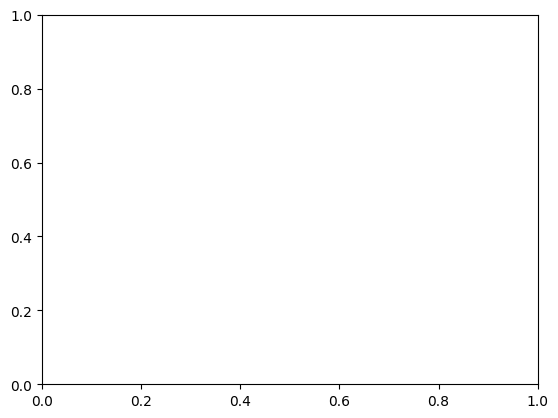

In [7]:
gs = [genre for genre in genres for i in range(len(features)//len(genres))]
gs_num = [j for j in range(len(genres)) for i in range(len(features)//len(genres))]
#color traces according to gs
colors = ['indianred','peru','mediumaquamarine','plum']
for n,f in enumerate(features):
    #plot line traces
    #join points with lines
    

In [50]:
labels = np.array([label for label in genres for _ in range(features.shape[0] // len(genres))])
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

#remove previous logs on windows
%reload_ext tensorboard

In [51]:
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True, write_images=True)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels_one_hot, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
# Build the model
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(genres), activation='softmax',kernel_regularizer=l2(0.001)))
# change the learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#add ROI as metric
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[tensorboard]
)

# Evaluate the model
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/1000
10/10 [==============================] - 2s 139ms/step - loss: 28.0620 - accuracy: 0.3125 - val_loss: 7.7356 - val_accuracy: 0.4750
Epoch 2/1000
10/10 [==============================] - 1s 131ms/step - loss: 6.9547 - accuracy: 0.4031 - val_loss: 3.3746 - val_accuracy: 0.5750
Epoch 3/1000
10/10 [==============================] - 1s 127ms/step - loss: 4.2040 - accuracy: 0.4219 - val_loss: 2.3513 - val_accuracy: 0.6375
Epoch 4/1000
10/10 [==============================] - 1s 126ms/step - loss: 3.5179 - accuracy: 0.4875 - val_loss: 2.1513 - val_accuracy: 0.7000
Epoch 5/1000
10/10 [==============================] - 1s 122ms/step - loss: 3.1232 - accuracy: 0.4906 - val_loss: 2.5070 - val_accuracy: 0.6125
Epoch 6/1000
10/10 [==============================] - 1s 123ms/step - loss: 3.0086 - accuracy: 0.5469 - val_loss: 2.1346 - val_accuracy: 0.6125
Epoch 7/1000
10/10 [==============================] - 1s 124ms/step - loss: 2.6945 - accuracy: 0.5875 - val_loss: 2.1270 - val_accuracy

Index:  0
Predicted:  1  Actual:  3
Index:  8
Predicted:  1  Actual:  0
Index:  9
Predicted:  3  Actual:  2
Index:  12
Predicted:  1  Actual:  2
Index:  16
Predicted:  2  Actual:  1
Index:  17
Predicted:  2  Actual:  0
Index:  25
Predicted:  3  Actual:  0
Index:  34
Predicted:  1  Actual:  2
Index:  37
Predicted:  1  Actual:  2
Index:  51
Predicted:  2  Actual:  0
Index:  52
Predicted:  3  Actual:  2
Index:  57
Predicted:  2  Actual:  3
Index:  76
Predicted:  2  Actual:  3
Index:  91
Predicted:  2  Actual:  3
Index:  99
Predicted:  0  Actual:  3
Index:  103
Predicted:  3  Actual:  2
Index:  116
Predicted:  3  Actual:  2
Index:  117
Predicted:  3  Actual:  1
Index:  122
Predicted:  1  Actual:  2
Index:  140
Predicted:  3  Actual:  2
Index:  150
Predicted:  2  Actual:  3
Index:  181
Predicted:  2  Actual:  1
Index:  188
Predicted:  1  Actual:  2
Index:  189
Predicted:  3  Actual:  2
Index:  196
Predicted:  3  Actual:  2
Index:  205
Predicted:  1  Actual:  0
Index:  207
Predicted:  1  Act